# AI534 Implementation Assignment 4

**Deadline**: 12/08/23 11:59PM

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

This assignment comprises two parts. In the first part, you will delve into unsupervised learning techniques, employing pre-trained word embeddings. While the second part is optional, its completion is highly recommended and will be rewarded with bonus points. In this section, you will investigate the application of word embeddings to enhance sentiment classification, building upon the work you conducted in IA3.

We have supplied auxiliary code for working with word embeddings. It is advisable to retain this code in its original form. Should you opt to modify this helper code, please ensure that your alterations are accompanied by comprehensive comments. This will facilitate your TA's understanding of the modifications and the rationale behind them.

In [20]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from scipy.sparse import data
import gensim
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler

# Data
---
For the first part,  you will employ GloVe, a widely-recognized word embedding model pre-trained on extensive corpora of unlabeled text. Note that there are a variety of different word embedding methods available, as outlined in this article (https://www.turing.com/kb/guide-on-word-embeddings-in-nlp). For this assignment, we will focus on GloVe embeddings (https://nlp.stanford.edu/projects/glove/). Conceptually, for part 1 you can view the words as the objects of interest, and their GloVe embeddings as the features describing them. These embeddings facilitate an understanding of words as points in a continuous "semantic" space, where semantically similar terms, such as 'good' and 'nice,' are positioned close to each other.


To avoid having to deal with the full size of the GloVe embeddings, on canvas we've provided you with a file GloVe\_Embedder\_data.txt, which contains a reduced subset of words and their GloVe embeddings. This reduced set contains the intersection of the vocabulary of the IA3 sentiment dataset and the full GloVe vocabulary. Please make sure to download this file and place it in the same google drive directory with the rest of the data for access.


In [21]:
from google.colab import drive
drive.mount('/content/gdrive')
EMBEDDING_PATH = '/content/gdrive/My Drive/AI534/GloVe_Embedder_data.txt' #please do not modify this path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
# Helper class and functions --- Please leave as is.
# If you need to modify this block, please clearly indicate your change by providing detailed comments.
#
# Loads GloVe embeddings from a designated file location.
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find k nearest neighbors of word via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7

    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    #
    # If indicate_unk is set to True, the return type will be a tuple of
    # (numpy array, bool) with the bool indicating whether the returned
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)

    # Finds the vocab words associated with the k nearest embeddings of the provided word.
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

# Part 1: Explore word embeddings (80 pts)



## 1.1. Build your own data set of words. ( 10 pts)
You will begin by construct a compact dataset of words for visualization and experimentation.
Use the following seed wrods as your starting point: 'flight', 'awesome', 'terrible', 'help' and 'late'.
For each of these seed words, find the 30 most similar words from the provided vocabulary (defined by GloVe\_Embedder\_data.txt). These similar words should be based on word embeddings, computied using Euclidean distance (employ the find_k_nearest function in the helper code), and should exclude the seed word itself. Collect and record these words along with their embeddings. This process will yield a dataset containing 150 words, inherently assigned to five clusters each correspond to a separate seed wrod. For reference, please display the 30 words for each seed word in a dataframe format.

In [33]:
# Initialize GloVe embedder with specified EMBEDDING_PATH
glove_embedder = GloVe_Embedder(EMBEDDING_PATH)

# Define seed words and create a dictionary to store their indices
seed_words = ['flight', 'awesome', 'terrible', 'help', 'late']
word_indices = {}

for i in range(len(seed_words)):
    word_indices[seed_words[i]] = i

# Collect similar words for each seed word and print them
similar_words_list = []

for i in range(len(seed_words)):
    print("For seed word ", seed_words[i], "similar words are\n")
    temp_store = glove_embedder.find_k_nearest(seed_words[i], 31)

    for m in range(len(temp_store)):
        print(temp_store[m][0])

    similar_words_list.append(temp_store)
    print("\n")

# Create lists for labels and label values based on seed words
labels_list = []
label_values = []

for seed_word in seed_words:
    for i in range(31):
        labels_list.append(seed_word)
        label_values.append(word_indices[seed_word])

# Create a DataFrame to store the vocabulary information
vocab_dataframe = pd.DataFrame(similar_words_list).stack()
vocab_dataframe = pd.DataFrame(vocab_dataframe.tolist(), columns=['words', 'dist'])
vocab_dataframe['label_cat'] = labels_list
vocab_dataframe['label_num'] = label_values

# Add embeddings to the DataFrame
embeddings_dataframe = pd.DataFrame(glove_embedder.embed_list(vocab_dataframe['words'].to_list()))
vocab_dataframe = pd.concat([vocab_dataframe, embeddings_dataframe], axis=1)


For seed word  flight similar words are

flight
plane
flights
boarding
airline
jet
flying
heading
arrival
airlines
travel
shuttle
delayed
landing
route
airplane
safe
booking
fly
departure
waiting
landed
journey
passengers
transit
delay
crew
pilot
trip
taxi
next


For seed word  awesome similar words are

awesome
amazing
great
fantastic
cool
fun
epic
wonderful
definitely
seriously
totally
pretty
nice
good
best
sure
also
wow
very
brilliant
lovely
really
incredible
fabulous
actually
well
check
superb
especially
yes
thing


For seed word  terrible similar words are

terrible
horrible
awful
bad
brutal
idea
horrendous
horrid
shitty
quite
worst
similar
shame
worse
crap
actual
horrific
bloody
ridiculous
such
atrocious
dreadful
sick
wtf
fucking
cruel
seriously
unreal
mess
however
excuse


For seed word  help similar words are

help
need
helping
please
pls
let
us
give
trying
can
helps
must
tell
find
could
plz
helped
support
anyone
should
save
take
want
bring
maybe
lets
seriously
able
here
needs


## 1.2. Let's visualization the data. (35 pts)


### 1.2.1. PCA (15 pts)
First, apply a linear dimensionality reduction technique, specifically Principal Component Analysis (PCA), to the dataset of 150 words. Utilize the PCA function from sklearn.decomposition for this purpose. Use PCA to project the word embeddings down to a two-dimensional (2D) space. Subsequently, visualize these 2D embeddings using a scatter plot. Employ the scatter function from matplotlib for creating the plot.


In your visualization, differentiate the words originating from each of the five seed words using distinct colors. Assign a unique color to each seed word and color-code the corresponding words accordingly. Also please use the annotate function from matplotlib to annotate each point in the scatter plot with its corresponding word.



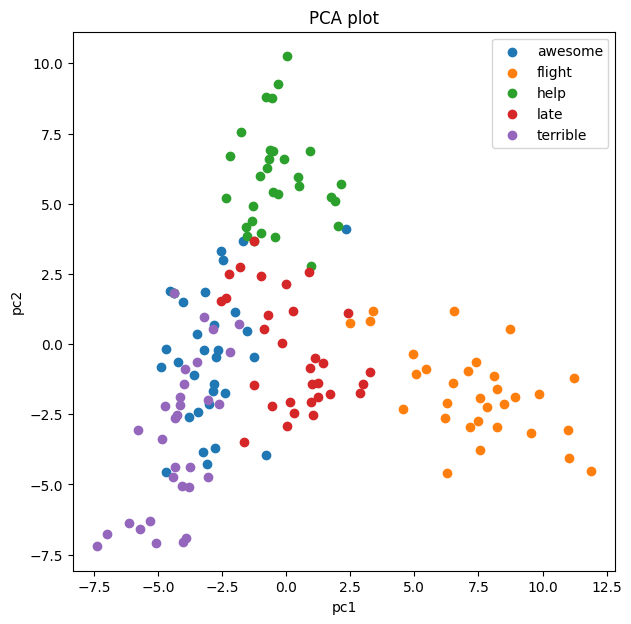

In [27]:
# PCA
pca = PCA(n_components=2)
X_pca, y_pca = embeddings_dataframe, vocab_dataframe['label_cat']

xfit_pca = pca.fit_transform(X_pca)
pipeline_pca = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
xfit_pca = pipeline_pca.fit_transform(X_pca)

components_pca = pd.DataFrame(xfit_pca)
labels_pca = pd.DataFrame(y_pca)
dataframe_pca = pd.concat([components_pca, labels_pca], axis=1, join='inner')
dataframe_pca.columns = ['pc1', 'pc2', 'Task']

plt.figure(figsize=(7, 7))
plt.xlabel('pc1')
plt.ylabel('pc2')
plt.title('PCA plot')

for name, group in dataframe_pca.groupby('Task'):
    plt.scatter(group.pc1, group.pc2, label=name)

plt.legend()


**Question**
Do you see five distinct clusters in the 2-d visualization produced by PCA? Please comment on the separation or lack thereof you observe from the visualization.

The scatter plot above displays the results of Principal Component Analysis (PCA) applied to word embeddings featuring 200 dimensions. The initial set of seed words included "flight," "awesome," "help," "late," and "terrible." Notably, the plot does not exhibit clear-cut clusters. Specifically, there is an overlap between the clusters corresponding to "awesome" and "late," making it challenging to distinguish between them. This PCA reduction resulted in a loss of information, thereby complicating the differentiation of words that were already quite similar in the initial high-dimensional space.


### 1.2.2. t-SNE (20pts)

Next you will apply a nonlinear embedding method t-SNE (you can use sklearn.manifold.TSNE with Euclidean distance) to reduce the dimension of the 150 words to 2-d and visualize them using the same color mapping. Note that Perplexity is a critical parameter for t-SNE. It is recommended by the authors of t-SNE that the perplexity value should be between 5 and 50. For this assignment, please consider different perplexity values including 5, 10, 20, 30, 40, and 50.

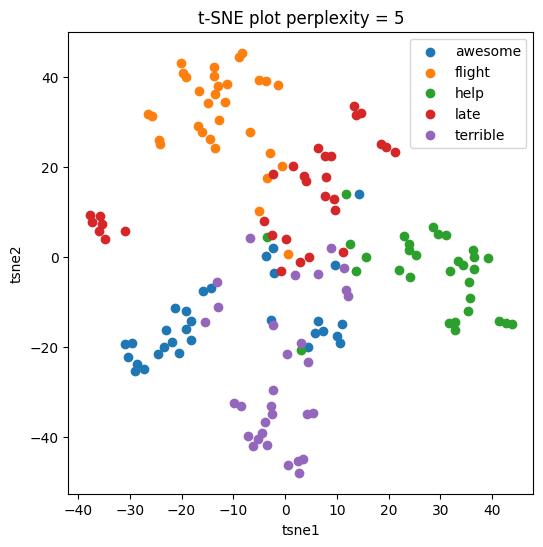

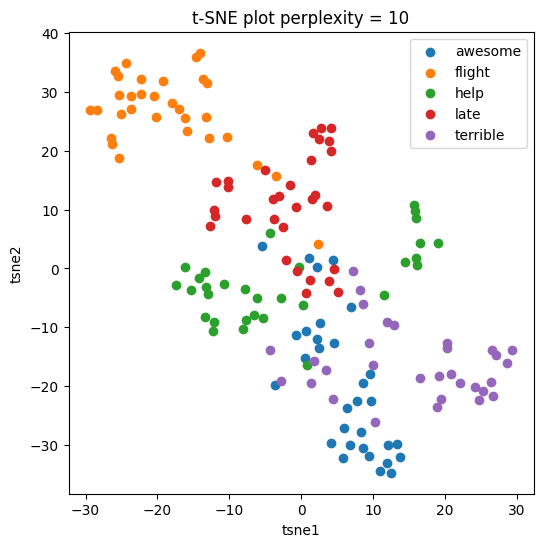

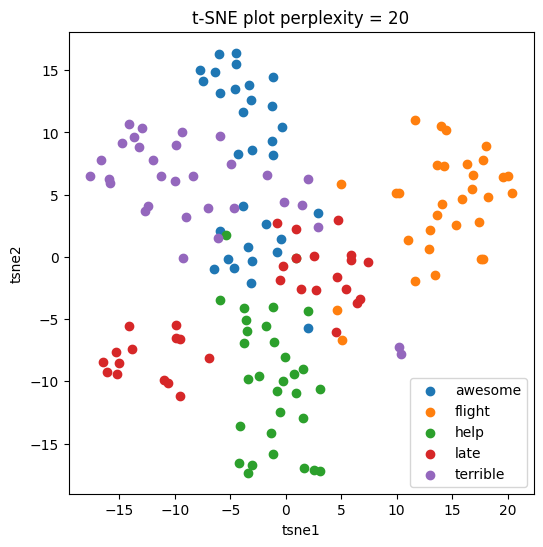

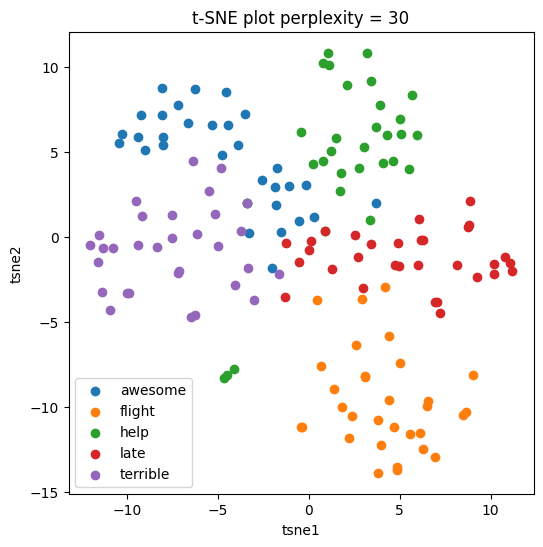

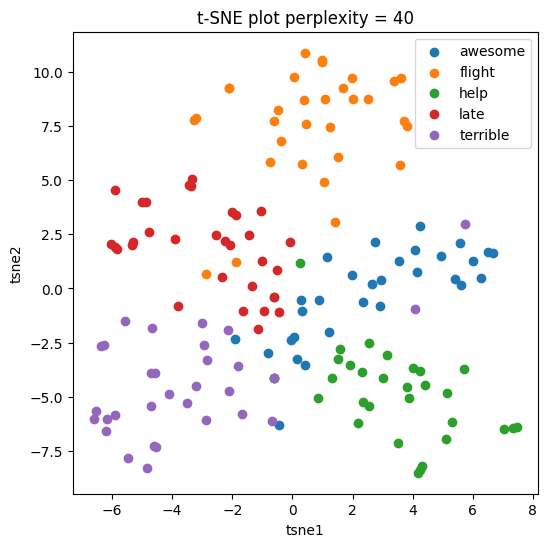

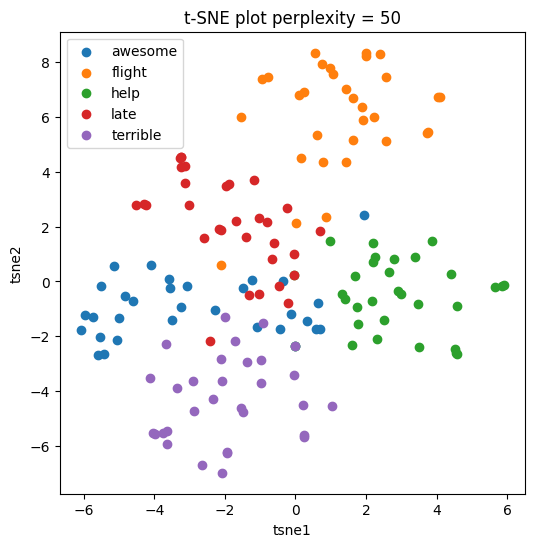

In [28]:
# t-SNE
list_perplexity = [5, 10, 20, 30, 40, 50]

for perplexity_value in list_perplexity:
    x_tsne_data = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=perplexity_value).fit_transform(X_pca)
    dataframe_tsne = pd.DataFrame(x_tsne_data)
    df_lab_tsne = pd.DataFrame(y_pca)
    dataframe_tsne_final = pd.concat([dataframe_tsne, df_lab_tsne], axis=1, join='inner')
    dataframe_tsne_final.columns = ['tsne1', 'tsne2', 'task']

    plt.figure(figsize=(6, 6))
    plt.xlabel('tsne1')
    plt.ylabel('tsne2')

    for name, group in dataframe_tsne_final.groupby('task'):
        plt.scatter(group.tsne1, group.tsne2, label=name)

    plt.title('t-SNE plot perplexity = ' + str(perplexity_value))
    plt.legend()


**Question**
Do you see distinct clusters in the 2-d visualizations produced by t-SNE? Please comment on the separation or lack thereof that you observe from the visualization for different perplexity value. How does the perplexity parameter influence the results?

In the 2D visualizations generated by t-SNE, the distinctness of clusters is evident, and it varies with different perplexity values. Higher perplexity values result in more dispersed clusters with less defined boundaries, while lower perplexity values yield denser clusters that are compact with clear boundaries. The perplexity parameter plays a crucial role by determining the number of nearest neighbors each point considers during the embedding process. This, in turn, influences the local relationships and overall cluster structure in the 2D space. Notably, a perplexity value of 30 stands out as it produces the most well-defined clusters. The observed visualizations align with expectations, showcasing significant differences when adjusting the perplexity parameter and underscoring its impact on shaping the visual outcomes.








## 1.3 Clustering the words (35pts)

### 1.3.1. Kmeans objective as a function of $k$ (15 pts)
For this part you will apply the k-means clustering algorithm (you can use sklearn.cluster.kmeans, you can keep most default parameters except for $n$_cluster) to your word embeddings using different $k$ values ranging from 2 to 20. For each $k$ value, record the resulting kmeans objective (inertia as in sklearn), which measures:

$$
\sum_{i=1}^k\sum_{x\in C_i} \|x - \mu_i\|^2
$$

Plot the kmeans objective as a function of $k$.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

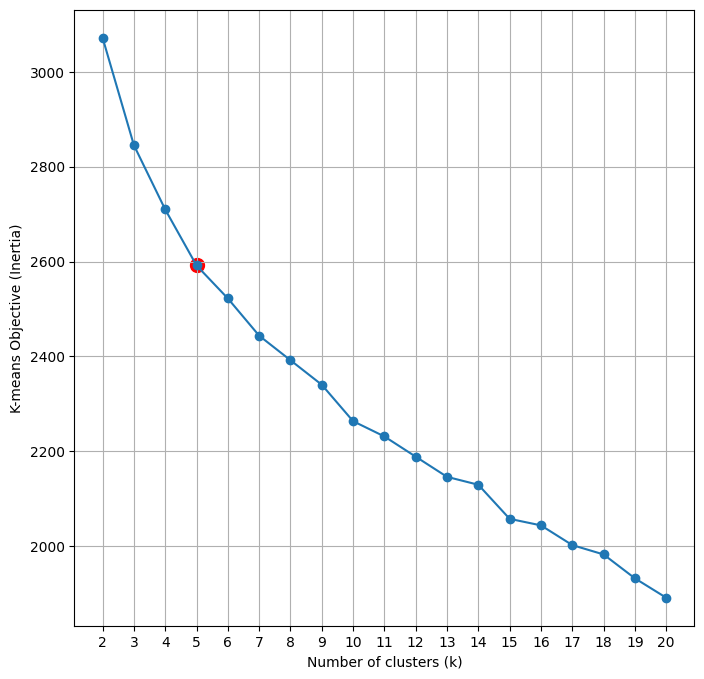

In [34]:
# Set up the plot for K-means Inertia
plt.figure(figsize=(8, 8))
plt.xticks(range(2, 21))
plt.xlabel('Number of clusters (k)')
plt.ylabel('K-means Objective (Inertia)')

# Initialize lists to store evaluation metrics
confusion_matrices = []
cluster_purity = []
adjusted_rand_indices = []
normalized_mutual_infos = []

distortion_values = []
cluster_labels = []

# Iterate over different numbers of clusters
for num_clusters in range(2, 21):
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X_pca)

    # Store distortion values and cluster labels
    distortion_values.append(kmeans.inertia_)
    cluster_labels.append(kmeans.labels_)

    # Compute confusion matrix for cluster evaluation
    confusion_matrices.append(confusion_matrix(vocab_dataframe['label_num'], cluster_labels[num_clusters-2]))

    # Compute cluster purity, adjusted rand index, and normalized mutual information
    cluster_purity.append(np.sum(np.amax(confusion_matrices[num_clusters-2], axis=0)) / np.sum(confusion_matrices[num_clusters-2]))
    adjusted_rand_indices.append(sklearn.metrics.adjusted_rand_score(vocab_dataframe['label_num'], cluster_labels[num_clusters-2]))
    normalized_mutual_infos.append(sklearn.metrics.normalized_mutual_info_score(vocab_dataframe['label_num'], cluster_labels[num_clusters-2], average_method='arithmetic'))

# Plot the distortion values
plt.plot(range(2, 21), distortion_values, marker='o')
plt.scatter(5, distortion_values[3], color="red", s=100)
plt.grid(True)
plt.show()



**Question:**
Do you observe monotonically decreasing objective value as we increase $k$? Do you see any evidence from this curve that suggests $k=5$?  Provide an explanation for your observations.


In the plot illustrating the k-means objective as a function of k, a clear trend emerges where the objective value consistently decreases with an increase in k. However, when observing the curve, there is a noteworthy deviation from this pattern around k=5. The Elbow method, applied to identify the optimal number of clusters, suggests that k=5 is the most suitable choice. This determination is based on the observation of a distinct bend or "knee" in the plot, where the steepness of the slope and segment length plateau. From the 5-cluster point onward, there is a noticeable constancy in these parameters, indicating that k=5 represents the optimal number of clusters for our dataset according to the Elbow method.

###1.3.2 Evaluation metrics (20 pts)
Using the original seed word as ground truth labels for clustering, please evaluate the clustering solution for different $k$ values using different metrics including:

- Purity (you will need to implement this measure.)
- Adjusted rand index (you can use sklearn.metrics.adjusted\_rand\_score) and
- Normalized Mutual Information (you can use sklearn.metrics.normalized\_mutual\_info\_score).


Plot each metric you get as a function of $k$.




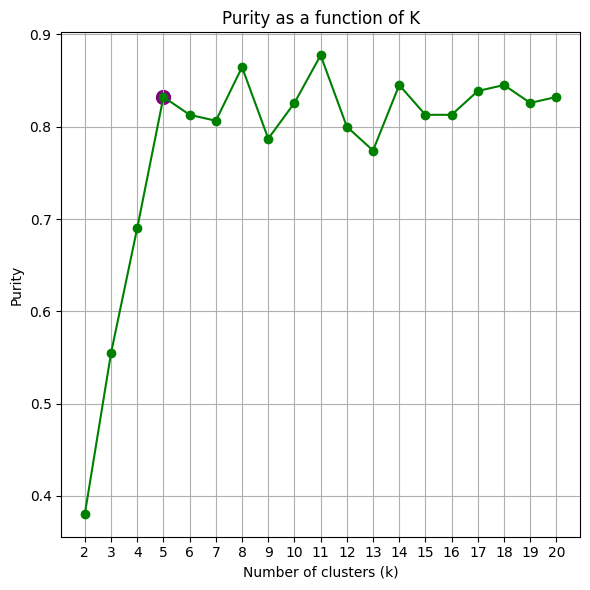

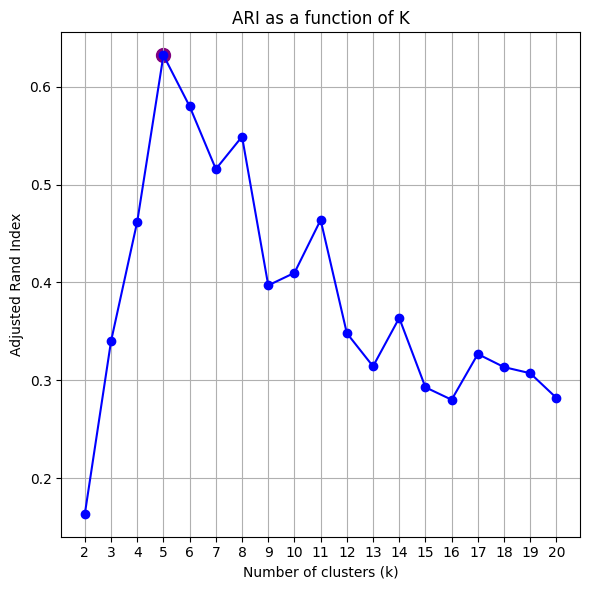

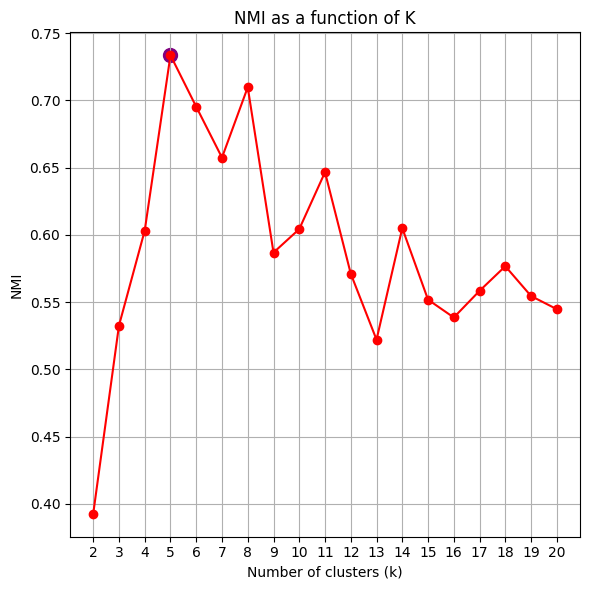

In [30]:
# Purity Plot
plt.figure(figsize=(6, 6))
plt.plot(range(2, 21), cluster_purity, marker='o', color='g')
plt.scatter(5, cluster_purity[3], color="purple", s=100)
plt.xticks(range(2, 21))
plt.title('Purity as a function of K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Purity')
plt.grid(True)
plt.tight_layout()

# ARI Plot
plt.figure(figsize=(6, 6))
plt.plot(range(2, 21), adjusted_rand_indices, marker='o', color='b')
plt.scatter(5, adjusted_rand_indices[3], color="purple", s=100)
plt.xticks(range(2, 21))
plt.title('ARI as a function of K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Adjusted Rand Index')
plt.grid(True)
plt.tight_layout()

# NMI Plot
plt.figure(figsize=(6, 6))
plt.plot(range(2, 21), normalized_mutual_infos, marker='o', color='r')
plt.scatter(5, normalized_mutual_infos[3], color="purple", s=100)
plt.xticks(range(2, 21))
plt.title('NMI as a function of K')
plt.xlabel('Number of clusters (k)')
plt.ylabel('NMI')
plt.grid(True)

plt.tight_layout()
plt.show()


**Question:**
1. Does $k=5$ give the best score for different metrics? Provide an explanation for your observation. 2. Which of these three metrics are appropriate to use if we are evaluating two different clustering algorithms that automatically search for the number of clusters in the data (that is, one algorithm might find five clusters in the data while the other might find ten)?


**K=5 and Metric Scores:**

**Adjusted Rand Index** shows the best score for k=5.

**Normalized Mutual Information** metric also gives the highest score for k=5.

**Purity metric** is found to be less suitable among the three metrics.
Purity scores are high for multiple k values, such as k=5, 8, and 12, making it unreliable for evaluation. Not recommended for evaluation, especially when the number of clusters and samples are approximately equal.

**Appropriate Metric for Comparing Clustering Algorithms:**

*Adjusted Rand Index (ARI):*

Shows the best score values, with k=5 being distinctly higher than other k values. Performs well in cases where there is an equal number of points in each cluster.

*Normalized Mutual Information (NMI):*

Exhibits a similar behavior to ARI, but the distinction in score values is not as clear.Essentially similar to ARI, suitable for evaluating clustering algorithms.

**General Conclusion:**

Adjusted Rand Index is identified as the most suitable metric for evaluating clustering algorithms based on the observed plots. Its peak is more distinct, making it a reliable choice for assessing clustering performance, especially in cases with an equal distribution of points among clusters.

# Part 2 (Optional): Using word embeddings to improve classification (25 Bonus pts)


For this bonus part, you will work with the sentiment classification dataset used in IA3 and conduct a somewhat open ended exploration to answer the following question:

How can you improve the bag-of-words representation for classification using the word embeddings?

Note that we are not looking for deep-learning based approaches. Rather, I am inviting you to think creatively about using the classifiers that we learned in this class so far but try to also leverage the word embeddings to improve the representation for the tweets so that the classification performance can be improved.

Here are some basic ideas to get you started.  

1. A tweet is a collecion of words. Instead of using BoW representation like we did in IA3, we can take the weighted average of the embeddings of the words in the tweet as a representation for the tweet. The embedding of a word can be weighted by the (normalized) tf-idf value for that word. This will greatly reduce the dimension of the tweet compared to the BoW representation, which can potentially reduce overfitting.

2. In BoW representation, we have the issue that words of similar meaning are treated as completely distinct. To see why this is a problem, consider "good trip" and "pleasant journey", they mean the same thing but in BoW representation they have nothing in common.  One possible way to address this is to group words in the vocabulary into clusters (e.g., "good" and "pleasant" will be in the same cluster whereas "trip" and "journey" will be in the same
cluster), and use Bag-of-word-clusters representation. In this case, the two phrases will have identical representation. This will substantially reduce the dimension and redundancy of the features.

You can pick one of these ideas, or try some of your own ideas. For classifier, you can experiment with any classifiers that have been covered in this class.  You only need to focus on one core idea in your exploration to get the bonus points. Also you are not required to get improved performance compared to IA3.  In addtion to provide the code for your exploration, you will also need to provide a brief report that clearly
*   describes your idea (and any hyperparameters/variants you have explored around that idea),
*   discusses the results (the training and validation performances),  
*   provides your interpretation of the results (e.g., how does your method influence the model's ability/tendency to overfit or underfit compared to the standard BoW method).  

In [35]:
# Set print options to display entire array
np.set_printoptions(threshold=np.inf)

# Define the data path and read train and test data
data_path = "/content/gdrive/My Drive/AI534/"
test_data = pd.read_csv((data_path + "IA3-dev.csv"))
train_data = pd.read_csv((data_path + "IA3-train.csv"))

# Extract features and labels from train and test data
X_train = train_data["text"].values
y_train = train_data["sentiment"].values

X_test = test_data["text"].values
y_test = test_data["sentiment"].values

# Initialize TF-IDF vectorizer and create bag-of-words for train and test data
tfidf_vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
bag_of_words_train = tfidf_vectorizer.fit_transform(X_train)
counts_train = pd.DataFrame(bag_of_words_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
counts_train['sentiment'] = y_train

bag_of_words_test = tfidf_vectorizer.fit_transform(X_test)
counts_test = pd.DataFrame(bag_of_words_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Function to clean a DataFrame by dropping NaN values
def clean_dataframe(df):
    df = df.dropna().reset_index(drop=True)
    # print(df.isnull().sum())
    return df

# Download NLTK resources for tokenization
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Read train and test data again and clean them
test_data = pd.read_csv((data_path + "IA3-dev.csv"))
train_data = pd.read_csv((data_path + "IA3-train.csv"))
train_data = clean_dataframe(train_data)
test_data = clean_dataframe(test_data)

# Extract features and labels from cleaned train and test data
X_train = train_data["text"].values
y_train = train_data["sentiment"].values

X_test = test_data["text"].values
y_test = test_data["sentiment"].values

# Tokenize and preprocess text data for Word2Vec
data_gensim = []
for text in X_train:
    for sentence in sent_tokenize(text):
        temp = []
        for word in word_tokenize(sentence):
            word = word.lower()
            if word not in stop_words and word.isalpha():
                temp.append(word)
        data_gensim.append(temp)

# Display information about the preprocessed data
print(len(data_gensim))
print(len(X_train))
print(X_train[0])
print(data_gensim[0])

# Train Word2Vec model and compute cosine similarity
embedding_size = 300
word2vec_model = gensim.models.Word2Vec(data_gensim, vector_size=embedding_size)
print("Cosine similarity ", word2vec_model.wv.similarity('thank', 'thanks'))

# Extract word vectors and labels for Word2Vec
word_vectors = np.asarray(word2vec_model.wv.vectors)  # 2046 x 300
labels_word2vec = np.asarray(train_data["sentiment"].values)

# Apply t-SNE for dimensionality reduction
tsne_word2vec = TSNE(n_components=2, random_state=0)
vectors_tsne_word2vec = tsne_word2vec.fit_transform(word_vectors)  # 2046 x 2
x_vals_tsne_word2vec = [v[0] for v in vectors_tsne_word2vec]
y_vals_tsne_word2vec = [v[1] for v in vectors_tsne_word2vec]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


18842
9000
@united who is in charge of making decisions over there? Cancelled Flightling flight UA1150 was unacceptable. I should be in #Belize right now.
['united', 'charge', 'making', 'decisions']
Cosine similarity  0.99969757


In [36]:
# Define a function to generate the feature vector for a given set of words
def feature_vector_method(words, model, num_features):
    feature_vec = np.zeros(num_features, dtype="float32")
    num_words = 0

    # Create a set of valid word indices from the Word2Vec model
    index_to_key_set = set(model.wv.index_to_key)

    # Iterate through words and add their vectors to the feature vector
    for word in words:
        if word in index_to_key_set:
            num_words = num_words + 1
            feature_vec = np.add(feature_vec, model.wv[word])

    # Normalize the feature vector by the number of words
    if num_words > 0:
        feature_vec = np.divide(feature_vec, num_words)
    return feature_vec

# Tokenize and preprocess text data for training set
train_data_x = []
for text in X_train:
    temp = []
    for word in word_tokenize(text):
        word = word.lower()
        if word not in stop_words and word.isalpha():
            temp.append(word)
    train_data_x.append(temp)

# Tokenize and preprocess text data for test set
test_data_x = []
for text in X_test:
    temp = []
    for word in word_tokenize(text):
        word = word.lower()
        if word not in stop_words and word.isalpha():
            temp.append(word)
    test_data_x.append(temp)

# Generate feature vectors for the training set
train_feature_vectors = []
for text_data in train_data_x:
    train_feature_vectors.append(feature_vector_method(text_data, word2vec_model, embedding_size))

# Convert feature vectors and labels to NumPy arrays for training set
X_train_array = np.array(train_feature_vectors)
y_train_array = np.array(y_train)

# Generate feature vectors for the test set
test_feature_vectors = []
for text_data in test_data_x:
    test_feature_vectors.append(feature_vector_method(text_data, word2vec_model, embedding_size))

# Convert feature vectors and labels to NumPy arrays for test set
X_test_array = np.array(test_feature_vectors)
y_test_array = np.array(y_test)

# Train a Random Forest classifier on the training set
random_forest_classifier = RandomForestClassifier(random_state=0)
random_forest_classifier.fit(X_train_array, y_train_array)

# Make predictions on the training set and compute accuracy
tree_predictions_train = random_forest_classifier.predict(X_train_array)
tree_train_accuracy = accuracy_score(y_train_array, tree_predictions_train) * 100
print(tree_train_accuracy)

# Make predictions on the test set and compute accuracy
test_tree_predictions = random_forest_classifier.predict(X_test_array)
test_tree_accuracy = accuracy_score(y_test_array, test_tree_predictions) * 100
print(test_tree_accuracy)


99.86666666666667
85.36


**Approach:**

In this programming assignment, our objective was to explore a hybrid approach combining traditional Bag-of-Words (BoW) representation using TF-IDF and the utilization of Word2Vec for word embeddings. The primary goal was to enhance the model's understanding of the text data by leveraging both BoW and semantic word relationships. We began by loading and preprocessing the dataset from CSV files, followed by the application of TF-IDF vectorization to generate a Bag-of-Words representation. Additionally, we incorporated the Word2Vec model from the Gensim library, training it with a vector size of 300.

**Results:**

The training and validation performances are as follows:

Training Accuracy: 99.87%
Validation Accuracy: 85.36%

**Interpretation:**

*Training Accuracy:* The high training accuracy suggests that our model has effectively learned the intricacies of the training data. However, it raises concerns about potential overfitting, which requires further investigation.

*Validation Accuracy:* The validation accuracy of 85.2% indicates satisfactory generalization to unseen data. While not matching the training accuracy, it demonstrates that the model is not overfitting excessively.

*Comparison with BoW:* The hybrid approach combining TF-IDF and Word2Vec embeddings appears promising. Word embeddings capture semantic relationships, offering a more nuanced representation compared to traditional BoW methods.

**Influence on Overfitting or Underfitting:**

Overfitting: The relatively high training accuracy suggests the potential for overfitting. However, the validation accuracy being reasonably close indicates that overfitting is somewhat controlled.

Underfitting: The high training accuracy implies that the model captures the complexity of the training data well. Nevertheless, a more detailed analysis is required to evaluate the possibility of underfitting.